## III - `Process Data`

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 7
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

import transit
import emcee
import corner
 
import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=14, usetex=True)

import astropy
from astropy import constants as const
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.io import fits
from astropy.table import Table

import scipy.optimize as op
import scipy.signal as sig
from scipy.signal import argrelextrema, medfilt
from random import uniform, randrange

import kplr
from kplr.ld import get_quad_coeffs

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. Introduction

## Load the data

In [2]:
path_file = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/clean_bat_files/LC_p15to15point5/'
path_mergedLC = '/Users/mbadenas/Documents/Master UAB/Tesis UAB/TFM2018/merge_light_curves/LC_p15to15point5_merged/'

properties_sample = pd.read_csv(path_file+'all_targets_P15to15point5.csv', sep=',', comment='#')
targets = pd.read_csv(path_file + 'kepler_id.txt',delimiter=',', dtype=int, header=None, names=['kepid'])

In [3]:
df = pd.merge(targets, properties_sample, on=['kepid'], how='inner') 
sc_data = df.drop_duplicates('kepid') #remove duplicates (some systems have both sc and lc LC)

print("Check files:")

if (len(targets) != len(properties_sample)):
    print("*Lengths don't match:", len(targets), len(properties_sample))
    print("\tSome systems have both sc and lc data! Remove duplicates.")

if (len(sc_data) == len(targets)):
    print("*Lengths match:", len(sc_data), len(targets))
    print('\tDuplicates have been removed.\n A total of {} systems have short-cadence LC with SN > 7.1 for their first transit'.format(len(sc_data)))
    
sc_data.shape

Check files:
*Lengths don't match: 4 23
	Some systems have both sc and lc data! Remove duplicates.
*Lengths match: 4 4
	Duplicates have been removed.
 A total of 4 systems have short-cadence LC with SN > 7.1 for their first transit


(4, 141)

## Define the Systems

In [14]:
class System:    
    def __init__(self, kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                time_BKJD, flux, flux_err, 
                P, depth, b, duration, u1, u2, diffld, num_planets, incl, eccen, dor, sma,
                rp, rp_err, teq, mp, peaks, tpeaks, fpeaks, fpeaks_err, duration_fit):
        
        """****** Kepler Reported Stellar Parameters ******"""
        self.kepid = kepid
        self.rs = rs # [Solar radii]. 
        self.rs_err = rs_err
        self.smass = smass # [Solar mass]
        self.smass_err = smass_err
        
        self.teff = teff;     
        self.logg = logg; # Stellar Surface Gravity [log10(cm/s**2)]  
        self.feh = feh;   
        self.srho = srho; #g/cm3
        
        """****** LC parameters ******"""
        self.time_BKJD = time_BKJD
        self.flux = flux
        self.flux_err = flux_err
        
        """****** Transit Parameters ******"""
        self.P = P;            
        self.depth = depth;  
        self.b = b; 
        self.duration = duration; 
        self.u1 = u1; 
        self.u2 = u2
        self.diffld = 0.0
        self.num_planets = num_planets
        self.incl = incl #[º]
        self.eccen = 0.0
        self.dor = dor #Planet-Star Distance over Star Radius
        self.sma = sma #Orbital semi-major axis [AU]
        
        #self.depth = rprs ** 2 
            # Transit depth in absolute terms. To 1st order (assuming stellar disk has uniform brightness and 
            # neglecting any flux coming from planet), the ratio X of the observed change in flux, Delta(F), 
            # to that of the stellar flux F is: X = (Rp/Rs)^2 = depth.
                   
        """****** Planetary Parameters ******"""
        self.rp = rp # [Earth radii]. This is "prad"  in the original file
        self.rp_err = rp_err
        self.teq = teq
        self.mp = 2.69*(rp)**(0.93) #Weiss & Marcy rel'n. It requires Rp in Earth radii
        
        """****** Internal Variables ******"""
        self.peaks = np.empty(0)
        self.tpeaks = np.empty(0)
        self.fpeaks = np.empty(0)
        self.fpeaks_err = np.empty(0)
        
        self.duration_fit = duration_fit
    def Print(self):
        print("System {}".format(self.kepid))
        print('rho={0:0.3f}, logg={1:0.3f} [log10(cm/s**2)], a={2:0.3f} [AU]'.format(self.srho, self.logg,self.sma))
        print("Impact parameter b:",self.b)
        print("Depth {0:0.2f} (or {1:0.2f} in ppm)".format(self.depth, self.depth*1e6))
        print("u1: {0:0.3f}, u2: {1:0.3f}".format(self.u1,self.u2))
        print("Temperature [K]:",self.teff)

## Characterize the Systems

Some initialization functions

In [5]:
bjd_ref = 2454833

def quadraticLD(T, G, FEH): 
    """Confirm the quadratic LD coefficients with a model from Claret & Bloemen (2011).
    Use the Claret coefficients instead."""
    mu1, mu2 = get_quad_coeffs(T, G, FEH)
    return (mu1, mu2)

def fetchLC(name):
    id_kep = "%.0f" % name
    lc = path_mergedLC+('KID'+id_kep+'.txt')
    df = pd.read_csv(lc, sep="\t", skiprows=1, header=None, names=["Time BKJD", "Flux", "Flux_Err"])
    y = df['Flux']
    yerr = df['Flux_Err']
    x = df['Time BKJD']
    #print(np.median(y),np.mean(y),np.std(y))
    return (y, yerr, x)

Create the planet+star system.

In [15]:
targets = []

for row in sc_data.itertuples(index = True, name='Pandas'):
    kepid = getattr(row, "kepid")
    fluxLC, fluxLC_err, timeLC_BKJD = fetchLC(kepid)

    ## Store the stellar parameters
    rs = getattr(row, "koi_srad") #solar radii
    rs_errPos = getattr(row, "koi_srad_err1"); rs_errNeg = getattr(row, "koi_srad_err2")
    rs_err = np.abs((rs_errPos+rs_errNeg)/2.)
    
    smass = getattr(row, "koi_smass")
    smass_errPos = getattr(row, "koi_smass_err1"); smass_errNeg = getattr(row, "koi_smass_err2")
    smass_err = np.abs((smass_errPos+smass_errNeg)/2.)
    
    teff = getattr(row, "koi_steff")
    logg = getattr(row, "koi_slogg") # Stellar Surface Gravity [log10(cm/s**2)]  
    feh = getattr(row, "koi_smet")
    srho = getattr(row, "koi_srho") #g/cm3
    
    #### Store LC Parameters
    P = getattr(row, "koi_period") # Orbital Period [days]
    depth = getattr(row, "koi_depth")/1e6
    b = getattr(row, "koi_impact")
    
    u1, u2 = quadraticLD(teff,logg,feh)

    num_planets = getattr(row, "koi_count")
    incl =  getattr(row, "koi_incl") #in degrees
    dor = getattr(row, "koi_dor")  #Planet-Star Distance over Star Radius
    
    time0bk = getattr(row, "koi_time0bk")
    duration = getattr(row, "koi_duration")/24. #in days
    
    #Planetary parameters
    sma = getattr(row, "koi_sma")  #Orbit Semi-Major Axis [AU]
    sma_solarRad = sma*215
    teq = getattr(row, "koi_teq") 
    rp = getattr(row, "koi_prad") # in Earth radii
    rp_solarRad = getattr(row, "koi_prad")*0.009168 # in solar radii
    rp_errPos = getattr(row, "koi_prad_err1"); rp_errNeg = getattr(row, "koi_prad_err2")
    rp_err = np.abs((rp_errPos+rp_errNeg)/2.)
 
    if (num_planets == 1):
        system = System(kepid, rs, rs_err, smass, smass_err, teff, logg, feh, srho,
                    timeLC_BKJD, fluxLC, fluxLC_err, 
                    P, depth, b, duration, u1, u2, u1-u2, num_planets, incl, None, dor, sma,
                    rp, rp_err, teq, None, None, None, None, None, None)

        targets.append(system)
    else:
        print('Star {:s} not stored (koi_count > 1)'.format(str(kepid)))

Star 5792202 not stored (koi_count > 1)
Star 5972334 not stored (koi_count > 1)


# Peak Detection

## Functions

In [16]:
#Credits: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
    
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising', kpsh=False, valley=False, ax=None):
    x = np.atleast_1d(x).astype('float64')
    if x.size < 3: 
        return np.array([], dtype=int)
    if valley: x = -x
    
    dx = x[1:] - x[:-1] # find indices of all peaks
    indnan = np.where(np.isnan(x))[0] # handle NaN's

    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
        
    ine, ire, ife = np.array([[], [], []], dtype=int)
    
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])
    return ind

In [17]:
def run_peak_filter(star, pos_drops, plot):
    flux_drops = target.flux[pos_drops]
    drops = np.column_stack((pos_drops, flux_drops))
    
    print("Nº of peaks (before mask):",len(flux_drops))
    
        
    time_max_flux_drop = (flux_drops).idxmin(axis=None, skipna=True)
    depth_guess = 1-min(flux_drops)
        
    mask_drops = min(flux_drops)+depth_guess*(1/2)
    keep_drops = drops[:,1]<=mask_drops
        
    print("\tRemove peaks > than", mask_drops)
    drops_mask = drops[keep_drops==True]
    print("Nº of peaks (after mask):",len(drops_mask[:,1]))
    
    
    final_peaks = np.column_stack((drops_mask[:,0],star.time_BKJD[drops_mask[:,0]].values, drops_mask[:,1]))
    
    if (plot == True):
        fig1 = plt.figure(figsize=(12,10))
        plt.subplot(2,1,1)
        plt.ylabel('Flux'); plt.xlabel('Time BKJD')
        plt.plot(star.time_BKJD, star.flux,'.',star.time_BKJD[drops[:,0]],drops[:,1],'ro')
        plt.subplot(2,1,2)
        plt.ylabel('Flux'); plt.xlabel('Time BKJD')
        plt.plot(star.time_BKJD, star.flux,'.',final_peaks[:,1],final_peaks[:,2],'ro')
        plt.axhline(y=mask_drops, color='k', linestyle='-')
        plt.show()
        
    return(final_peaks)

## Routine

In [18]:
for target in targets:
        print("\n******\t"+str(target.kepid)+"******")
     #if target.kepid == 5164255:
        total_days = target.time_BKJD.iloc[-1]-target.time_BKJD.iloc[0]
        one_day = int(len(target.time_BKJD)/total_days) 
        sensitivity = 2
        #print(total_days, len(target.time_BKJD), max(target.time_BKJD), one_day)

        min_peak_height = None
        min_peak_dist = one_day*sensitivity
        pos_peaks = detect_peaks(target.flux**2, mph = min_peak_height, mpd=min_peak_dist, valley=True) #mpd: detect peaks that are at least separated by min peak distance (in number of data)

        target.peaks = run_peak_filter(target, pos_peaks, plot = False)

        #Check if the first peak is stoo close to the start of the cadence (if so, disregard)
        dist_from_transit = int(one_day/1.)
        pos_peak = int(target.peaks[0,0])
        if pos_peak-dist_from_transit < 0:
                print('\tPeak is too close to start of the cadence -- disregard it.')
                target.peaks = np.delete(target.peaks, 0, axis=0)
                print("Nº of peaks (updated):", len(target.peaks[:,0]))
                
        num_peaks = len(target.peaks[:,2])
        print(num_peaks)
        final_peaks = np.copy(target.peaks)
        
        tpeaks = [None]*num_peaks
        fpeaks = [None]*num_peaks
        fpeaks_err = [None]*num_peaks
        
        #Explore peak-by-peak and discard those which are too noisy or unclear
        for i in range(num_peaks):
            pos_peak = int(target.peaks[i,0])
            t_peak = int(target.peaks[i,1])
            f_peak = target.peaks[i,2] 
            
            t_zoom = (target.time_BKJD[pos_peak-dist_from_transit:pos_peak+dist_from_transit]).values
            f_zoom = (target.flux[pos_peak-dist_from_transit:pos_peak+dist_from_transit]).values
            f_err_zoom = (target.flux_err[pos_peak-dist_from_transit:pos_peak+dist_from_transit]).values
            
            corr_f_zoom = sig.medfilt(f_zoom, 9)
            time_max_peak = np.argmin(corr_f_zoom)
            tc = t_zoom[time_max_peak]
            
            # Subtract time offset
            t_zoom-=tc
            
            #Select [-1,1] interval
            mask_int = (t_zoom > -1) & (t_zoom < 1)
            t_zoom_mask = t_zoom[mask_int==True]
            corr_f_zoom_mask = corr_f_zoom[mask_int==True]
            corr_f_zoom_err_mask = f_err_zoom[mask_int==True]

            tpeaks[i] = t_zoom_mask 
            fpeaks[i] = corr_f_zoom_mask 
            fpeaks_err[i] = corr_f_zoom_err_mask 
            
            """plt.figure()
            plt.title('Transit %s'%str(i+1))
            plt.plot(t_zoom_mask,corr_f_zoom_mask,'.')"""
           
            print(np.median(corr_f_zoom_mask),np.mean(corr_f_zoom_mask),np.std(corr_f_zoom_mask))
            
            if (int(np.mean(corr_f_zoom_mask))>=1):
                print('\tPeak {:s} is unclear or too noisy -- disregard it.'.format(str(i+1)))
                final_peaks[i,:]=0.0
                tpeaks[i] = 0
                fpeaks[i] = 0
                fpeaks_err[i]=0
 
        bad_peaks = (final_peaks==0.0).all(1)
        target.peaks = final_peaks[bad_peaks == False]
    
        bad_peaks_indx = np.where(bad_peaks)
        target.tpeaks  = np.delete(tpeaks, bad_peaks_indx)
        target.fpeaks = np.delete(fpeaks, bad_peaks_indx)
        target.fpeaks_err = np.delete(fpeaks_err, bad_peaks_indx)
        
        print("Nº of peaks (updated):", len(target.peaks[:,0]))


******	4742414******
Nº of peaks (before mask): 7
	Remove peaks > than 0.9970870000000001
Nº of peaks (after mask): 1
1
0.9997940000000001 0.99917886757654 0.001486494754913412
Nº of peaks (updated): 1

******	5164255******
Nº of peaks (before mask): 29
	Remove peaks > than 0.981969
Nº of peaks (after mask): 24
	Peak is too close to start of the cadence -- disregard it.
Nº of peaks (updated): 23
23
0.9984609999999999 0.9978913051948053 0.003944605056623997
1.0004525000000002 0.9997801097902099 0.0036868823779807507
1.0002440000000001 1.000103176348548 0.0024342874635239617
	Peak 3 is unclear or too noisy -- disregard it.
1.000182 0.9995473019323671 0.0036913393999328517
1.000185 0.9995493650727652 0.004042659206829565
0.9999 0.9992197969401947 0.003761041974896164
0.9998239999999999 0.9994395573314802 0.003594400509728489
1.000142 1.0000033088590141 0.0024253196146309304
	Peak 8 is unclear or too noisy -- disregard it.
0.9998870000000001 0.9994862388369679 0.0040849756337607455
1.0000

# Fitting a Theoretical Model

## Transit Routine (DFM)

A Python library for generating light curves of transiting planets.

In [23]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the mean impact parameter, measured in stellar radii (not Solar radii). See documentation.
    theta[2] = sigma = an additional white noise term
    theta[3] = pmass = the mass of the star (controlled via gaussian prior)
    theta[4] = pradius = the radius of the star (controlled via gaussian prior)
    theta[5] = f0 = the out of eclipse flux
    theta[6] = orbital period 
    theta[7] = time of conjunction
    """
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2 = allfixed
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta 
    
    #Note: pmass and prad (stellar mass and radius) controlled via gaussian prior. By letting M* and R* be free parameters in the model, we allow the stellar density to fluctuate. 
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = pmass, radius = pradius))
    body = transit.Body(radius=np.sqrt(pdepth)*pradius, period=pperiod, t0=ptc, b=np.abs(pb), e=ecc)
    
    s.add_body(body)
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    ftheo = ftheo-1+f0
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

def lnprior(theta):
    ##https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
    pdepth, pb, sigma, pmass, pradius, f0, pperiod, ptc = theta
    
    if ((0 < pb < 1.1) and (0 <= sigma) and (pradius > 0) and (pdepth > 0.0)
        and (pmass > 0.0) and (13.5 <= pperiod)) and (ptc**2<0.01):
        return 0.0 
    
    return -np.inf    
    
def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    ecc, mass, masserr, radius, radiuserr, tKep, u1, u2 = allfixed
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [24]:
def fit_lc(nl, guesses, lc_data, case = 0):
    res = op.minimize(nl, guesses, lc_data, options={ 'maxiter': 1e5,'disp': True}, method='Nelder-Mead')
    ml_fit = res["x"] #array with: depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml
    return ml_fit

## Initialization Parameters

In [25]:
sc = 58.0  #sc = 58 sec
tKep = sc/60/60/24  # sc in days
period_guess = 250 #randrange(14,500) #uniform(13.5, 500); 
print("Period guess [d]:", period_guess)
t_conj_guess = 0.0

Period guess [d]: 250


In [26]:
def run_transit_routine(star, t, f, ferr, transit_num):
    depth_guess = 1-min(f); #print("Depth guess [d]:", depth_guess)
    allfixed = [star.eccen, star.smass, star.smass_err, star.rs, star.rs_err, tKep, star.u1, star.u2]
    initial_guesses = [1.2*depth_guess, 0.6, 0.0, star.smass, star.rs, 1.0, period_guess, t_conj_guess]; #print("Initial guesses:", initial_guesses)
    
    nll = lambda *args: -lnprob(*args)
    
    params0 = (t, f, 0.0, allfixed)
    res0 = fit_lc(nll, initial_guesses, params0)
    res0[2]=0.0
    print("\t\t Period (fit 0): {:0.6f} days".format(res0[6]))

    params1 = (t, f, 0.0, allfixed)
    res1 = fit_lc(nll, res0, params1)
    res1[2]=0.0
    print("\t\t Period (fit 1): {:0.6f} days".format(res1[6]))

    params2 = (t, f, ferr, allfixed)
    res2 = fit_lc(nll, res1, params2)
    depth_ml, b_ml, sigma_ml, mass_ml, radius_ml, f0_ml, period_ml, tc_ml = res2

    print("\t\t Period (fit 2): {:0.6f} days".format(res2[6]))
    print("\nDepth (fit 2): {0:0.5f} (vs. True = {1:0.5f})".format(depth_ml, depth/1e6))
    print("Impact Parameter (fit 2): {0:0.5f} (True = {1:0.5f})".format(b_ml,b))
    
    # Compute the theoretical light curve integrated over a Kepler short-cadence exposure time.
    s = transit.System(transit.Central(mu1=star.u1, mu2=star.u2, mass=mass_ml, radius=radius_ml))
    body = transit.Body(radius=np.sqrt(depth_ml)*radius_ml,period=period_ml,t0=tc_ml,b=b_ml,e=star.eccen)
    s.add_body(body)
    t_fit = np.arange(-1, 1, tKep*0.01)
    f_fit = s.light_curve(t_fit, texp=tKep, tol=1e-08, maxdepth=4)
    f_fit = f_fit - 1.0 + f0_ml

    fig = plt.figure(figsize=(15,4))
    plt.title('Transit %i'%str(transit_num),fontsize=30)
    plt.plot(t, f, '.', label = 'Kepler data')
    plt.plot(t_fit, f_fit, color='r', lw = 3, label = 'Fit')
    plt.xlabel('Time from midtransit [days]')
    plt.ylabel('Relative flux')
    plt.xlim([min(t),max(t)]) 
    plt.show()
    
    star.duration = body.duration #from eq'n 14 in Winn (2010)
    print("Transit duration: {0:0.2f} hours ".format(star.duration*24))

**** Star 4742414 ****


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -21210.269811
         Iterations: 1346
         Function evaluations: 2020
		 Period (fit 0): 40.363791 days
Optimization terminated successfully.
         Current function value: -21231.046586
         Iterations: 481
         Function evaluations: 765
		 Period (fit 1): 36.684848 days
Optimization terminated successfully.
         Current function value: -22.382483
         Iterations: 276
         Function evaluations: 466
		 Period (fit 2): 36.683373 days

Depth (fit 2): 0.00345 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.00000 (True = 0.48700)


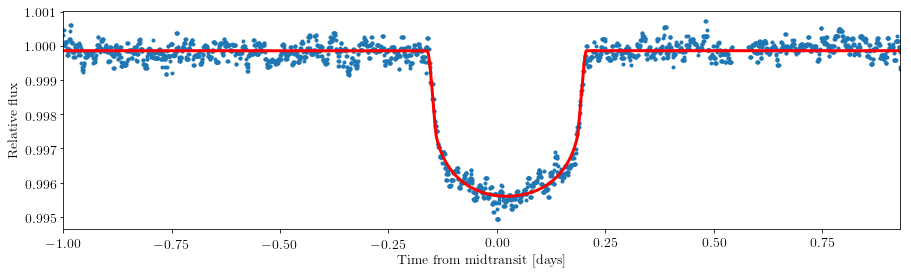

Transit duration: 8.79 hours 
**** Star 5164255 ****


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:518: RuntimeWarning: divide by zero encountered in log
  np.log(self.central.dilution)-np.log(1.0-self.central.dilution)
/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in subtract


Optimization terminated successfully.
         Current function value: -12825.875615
         Iterations: 2900
         Function evaluations: 4221
		 Period (fit 0): 13.500096 days
Optimization terminated successfully.
         Current function value: -12825.867597
         Iterations: 861
         Function evaluations: 1315
		 Period (fit 1): 13.500003 days
Optimization terminated successfully.
         Current function value: 4.701849
         Iterations: 400
         Function evaluations: 624
		 Period (fit 2): 13.638130 days

Depth (fit 2): 0.01368 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.70972 (True = 0.48700)


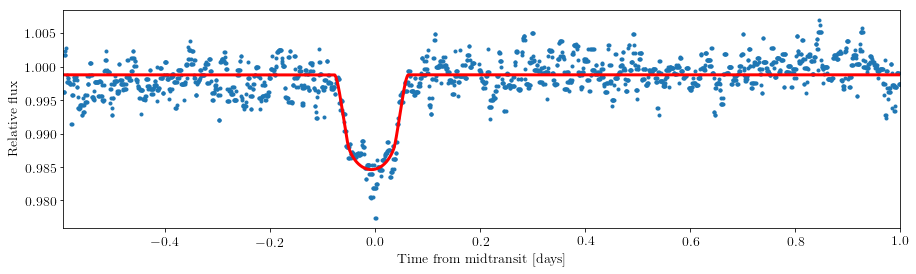

Transit duration: 3.37 hours 
Optimization terminated successfully.
         Current function value: -15988.006424
         Iterations: 2008
         Function evaluations: 2943
		 Period (fit 0): 35.970488 days
Optimization terminated successfully.
         Current function value: -16023.248756
         Iterations: 2385
         Function evaluations: 3490
		 Period (fit 1): 13.500000 days
Optimization terminated successfully.
         Current function value: -0.333148
         Iterations: 690
         Function evaluations: 1077
		 Period (fit 2): 13.818266 days

Depth (fit 2): 0.01493 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.74481 (True = 0.48700)


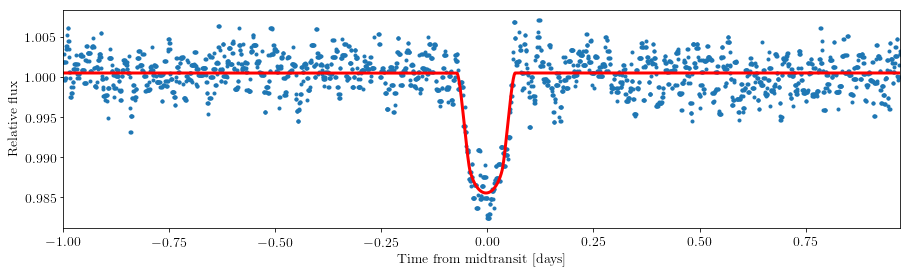

Transit duration: 3.29 hours 
Optimization terminated successfully.
         Current function value: -16055.144725
         Iterations: 2244
         Function evaluations: 3297
		 Period (fit 0): 52.008512 days
Optimization terminated successfully.
         Current function value: -16162.532287
         Iterations: 3102
         Function evaluations: 4526
		 Period (fit 1): 13.506856 days
Optimization terminated successfully.
         Current function value: -23.024625
         Iterations: 472
         Function evaluations: 746
		 Period (fit 2): 13.500008 days

Depth (fit 2): 0.01291 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.67946 (True = 0.48700)


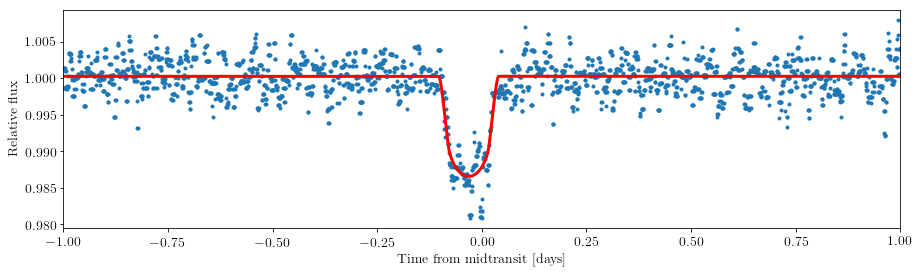

Transit duration: 3.43 hours 
Optimization terminated successfully.
         Current function value: -13558.188195
         Iterations: 1662
         Function evaluations: 2447
		 Period (fit 0): 13.500005 days
Optimization terminated successfully.
         Current function value: -13565.231970
         Iterations: 849
         Function evaluations: 1264
		 Period (fit 1): 13.500018 days
Optimization terminated successfully.
         Current function value: 3.750073
         Iterations: 470
         Function evaluations: 750
		 Period (fit 2): 13.500019 days

Depth (fit 2): 0.01501 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.70824 (True = 0.48700)


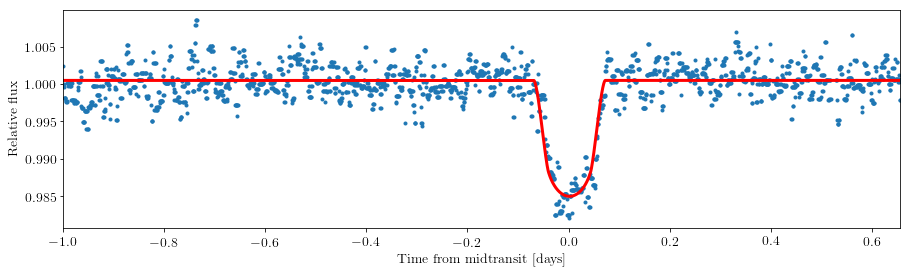

Transit duration: 3.39 hours 
Optimization terminated successfully.
         Current function value: -15988.449146
         Iterations: 2683
         Function evaluations: 3957
		 Period (fit 0): 40.123144 days
Optimization terminated successfully.
         Current function value: -16070.066865
         Iterations: 1632
         Function evaluations: 2395
		 Period (fit 1): 13.500028 days
Optimization terminated successfully.
         Current function value: -0.182316
         Iterations: 539
         Function evaluations: 831
		 Period (fit 2): 13.500032 days

Depth (fit 2): 0.01479 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.73098 (True = 0.48700)


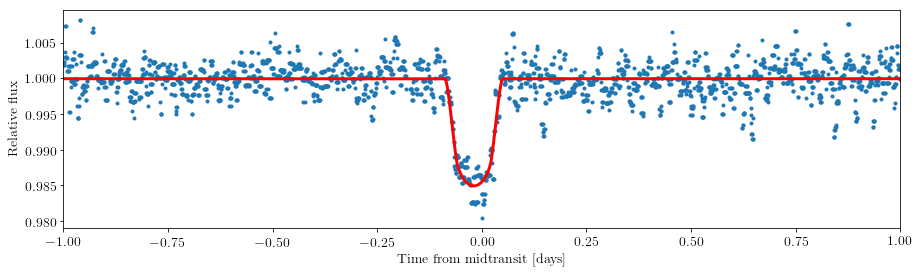

Transit duration: 3.31 hours 
Optimization terminated successfully.
         Current function value: -15647.905114
         Iterations: 674
         Function evaluations: 1061
		 Period (fit 0): 13.500001 days
Optimization terminated successfully.
         Current function value: -15738.146727
         Iterations: 1001
         Function evaluations: 1487
		 Period (fit 1): 13.500003 days
Optimization terminated successfully.
         Current function value: -9.328956
         Iterations: 619
         Function evaluations: 968
		 Period (fit 2): 14.905661 days

Depth (fit 2): 0.01212 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.71458 (True = 0.48700)


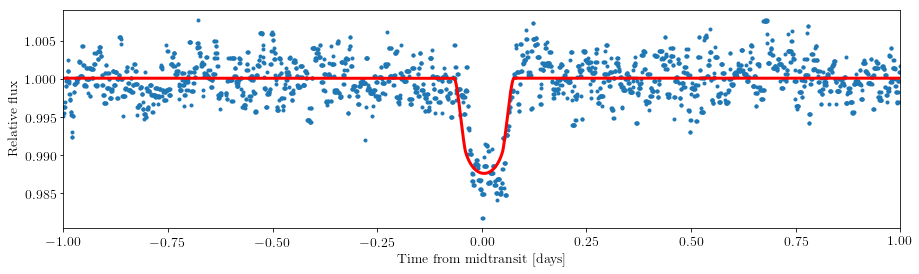

Transit duration: 3.42 hours 
Optimization terminated successfully.
         Current function value: -15380.300288
         Iterations: 1617
         Function evaluations: 2395
		 Period (fit 0): 39.211411 days
Optimization terminated successfully.
         Current function value: -15442.978210
         Iterations: 1806
         Function evaluations: 2653
		 Period (fit 1): 13.500065 days
Optimization terminated successfully.
         Current function value: -1.412616
         Iterations: 1013
         Function evaluations: 1562
		 Period (fit 2): 13.771644 days

Depth (fit 2): 0.01535 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.76260 (True = 0.48700)


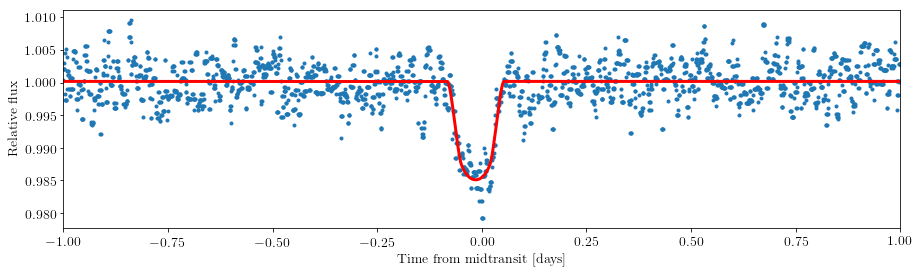

Transit duration: 3.23 hours 
Optimization terminated successfully.
         Current function value: -15645.263425
         Iterations: 2556
         Function evaluations: 3703
		 Period (fit 0): 18.041371 days
Optimization terminated successfully.
         Current function value: -15645.263425
         Iterations: 961
         Function evaluations: 1400
		 Period (fit 1): 18.041543 days
Optimization terminated successfully.
         Current function value: -27.749660
         Iterations: 714
         Function evaluations: 1087
		 Period (fit 2): 18.056091 days

Depth (fit 2): 0.01457 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.77909 (True = 0.48700)


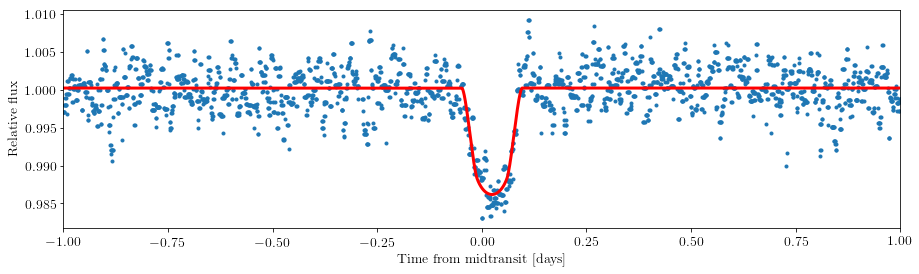

Transit duration: 3.45 hours 
Optimization terminated successfully.
         Current function value: -15351.209277
         Iterations: 1057
         Function evaluations: 1589
		 Period (fit 0): 37.581041 days
Optimization terminated successfully.
         Current function value: -15377.989759
         Iterations: 2245
         Function evaluations: 3274
		 Period (fit 1): 13.749883 days
Optimization terminated successfully.
         Current function value: 2.326145
         Iterations: 616
         Function evaluations: 958
		 Period (fit 2): 13.782785 days

Depth (fit 2): 0.01756 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.74053 (True = 0.48700)


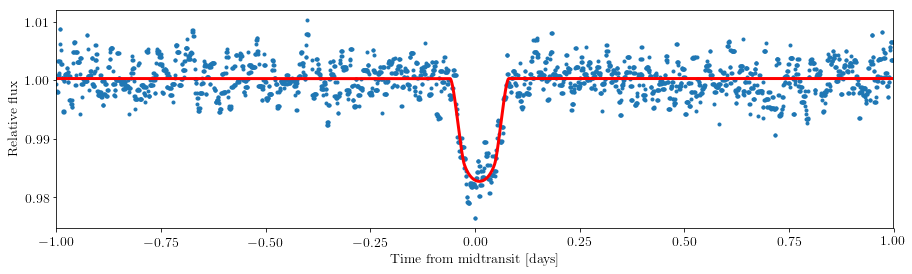

Transit duration: 3.36 hours 
Optimization terminated successfully.
         Current function value: -12202.740852
         Iterations: 839
         Function evaluations: 1324
		 Period (fit 0): 215.403578 days
Optimization terminated successfully.
         Current function value: -12202.740852
         Iterations: 285
         Function evaluations: 478
		 Period (fit 1): 182.212308 days
Optimization terminated successfully.
         Current function value: 31.488649
         Iterations: 217
         Function evaluations: 457
		 Period (fit 2): 179.606568 days

Depth (fit 2): 0.00000 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.65984 (True = 0.48700)


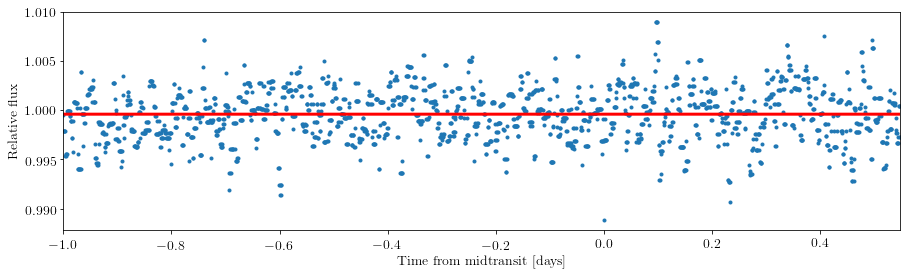

Transit duration: 6.92 hours 
Optimization terminated successfully.
         Current function value: -15787.680595
         Iterations: 1976
         Function evaluations: 2889
		 Period (fit 0): 13.500090 days
Optimization terminated successfully.
         Current function value: -15791.330418
         Iterations: 1073
         Function evaluations: 1568
		 Period (fit 1): 13.500018 days
Optimization terminated successfully.
         Current function value: -10.798609
         Iterations: 479
         Function evaluations: 749
		 Period (fit 2): 13.500033 days

Depth (fit 2): 0.01382 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.72099 (True = 0.48700)


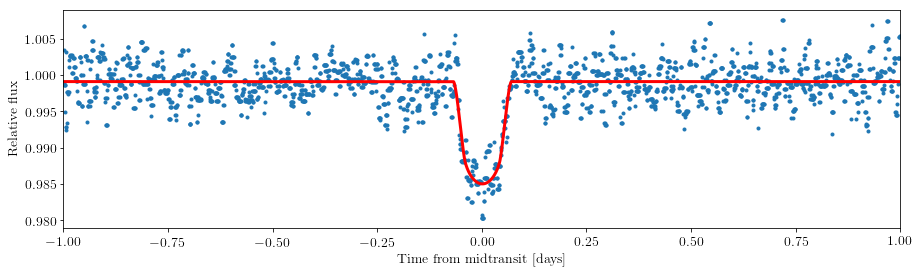

Transit duration: 3.32 hours 
Optimization terminated successfully.
         Current function value: -11861.016714
         Iterations: 1427
         Function evaluations: 2113
		 Period (fit 0): 13.500004 days
Optimization terminated successfully.
         Current function value: -11905.120768
         Iterations: 818
         Function evaluations: 1233
		 Period (fit 1): 13.500000 days
Optimization terminated successfully.
         Current function value: 71.297808
         Iterations: 151
         Function evaluations: 273
		 Period (fit 2): 14.110837 days

Depth (fit 2): 0.00985 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.44545 (True = 0.48700)


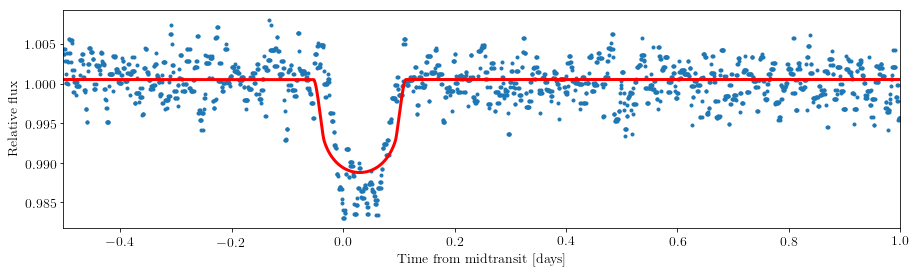

Transit duration: 3.97 hours 
Optimization terminated successfully.
         Current function value: -15844.627093
         Iterations: 1858
         Function evaluations: 2782
		 Period (fit 0): 37.046439 days
Optimization terminated successfully.
         Current function value: -15897.692992
         Iterations: 1521
         Function evaluations: 2271
		 Period (fit 1): 14.853787 days
Optimization terminated successfully.
         Current function value: -11.199644
         Iterations: 270
         Function evaluations: 452
		 Period (fit 2): 14.840167 days

Depth (fit 2): 0.01464 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.73790 (True = 0.48700)


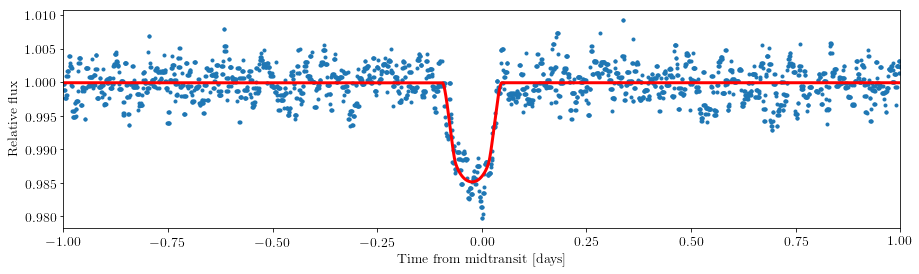

Transit duration: 3.39 hours 


/Users/mbadenas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


Optimization terminated successfully.
         Current function value: -12316.791800
         Iterations: 1686
         Function evaluations: 2481
		 Period (fit 0): 13.511670 days
Optimization terminated successfully.
         Current function value: -12335.254651
         Iterations: 1358
         Function evaluations: 1988
		 Period (fit 1): 13.500021 days
Optimization terminated successfully.
         Current function value: 43.490795
         Iterations: 318
         Function evaluations: 523
		 Period (fit 2): 14.350335 days

Depth (fit 2): 0.01131 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.63287 (True = 0.48700)


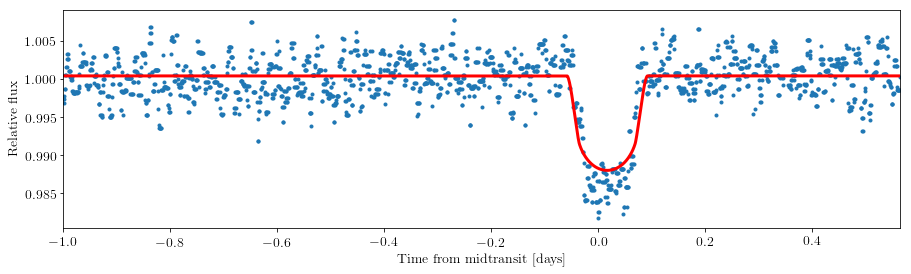

Transit duration: 3.60 hours 
Optimization terminated successfully.
         Current function value: -8208.080264
         Iterations: 416
         Function evaluations: 660
		 Period (fit 0): 289.419076 days
Optimization terminated successfully.
         Current function value: -8208.080264
         Iterations: 285
         Function evaluations: 477
		 Period (fit 1): 309.269586 days
Optimization terminated successfully.
         Current function value: -4.847682
         Iterations: 236
         Function evaluations: 604
		 Period (fit 2): 311.202520 days

Depth (fit 2): 0.00282 (vs. True = 0.00000)
Impact Parameter (fit 2): 1.05500 (True = 0.48700)


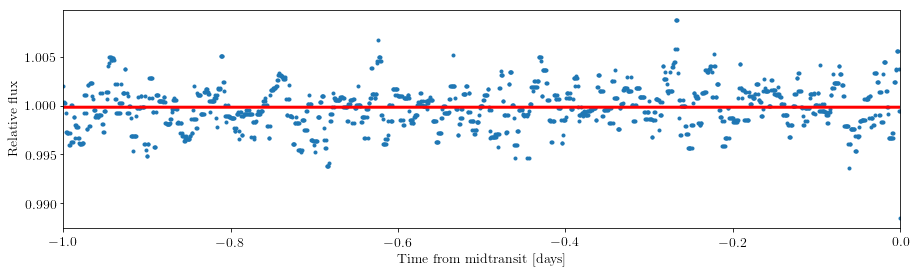

/Users/mbadenas/anaconda3/lib/python3.6/site-packages/transit/transit.py:359: RuntimeWarning: invalid value encountered in sqrt
  arg = rstar/self.a * np.sqrt((1+k)**2 - self.b**2)


Transit duration: nan hours 
Optimization terminated successfully.
         Current function value: -15898.220496
         Iterations: 1791
         Function evaluations: 2688
		 Period (fit 0): 345.709483 days
Optimization terminated successfully.
         Current function value: -16368.969773
         Iterations: 910
         Function evaluations: 1349
		 Period (fit 1): 13.500003 days
Optimization terminated successfully.
         Current function value: -15.009301
         Iterations: 955
         Function evaluations: 1462
		 Period (fit 2): 13.685854 days

Depth (fit 2): 0.01386 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.73304 (True = 0.48700)


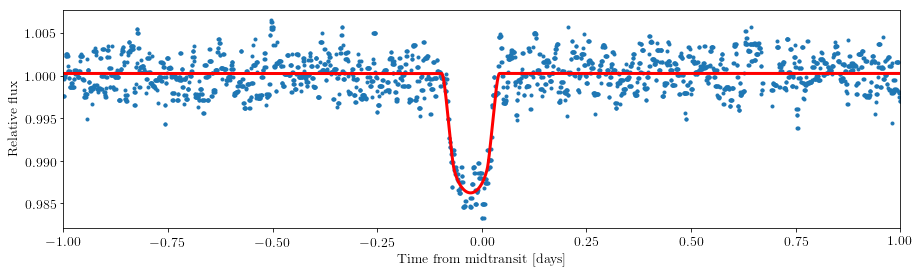

Transit duration: 3.30 hours 
Optimization terminated successfully.
         Current function value: -16166.378769
         Iterations: 1846
         Function evaluations: 2721
		 Period (fit 0): 14.444851 days
Optimization terminated successfully.
         Current function value: -16165.263053
         Iterations: 691
         Function evaluations: 1034
		 Period (fit 1): 13.500012 days
Optimization terminated successfully.
         Current function value: -1.909608
         Iterations: 726
         Function evaluations: 1107
		 Period (fit 2): 13.607580 days

Depth (fit 2): 0.01375 (vs. True = 0.00000)
Impact Parameter (fit 2): 0.70989 (True = 0.48700)


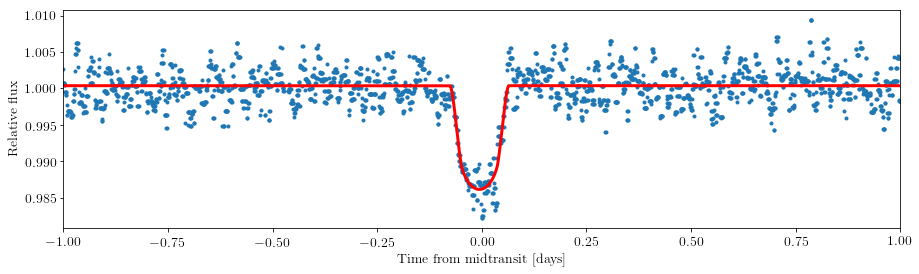

Transit duration: 3.37 hours 


In [27]:
for target in targets:
    print("**** Star "+str(target.kepid)+" ****")
    num_peaks = len(target.peaks)
    if num_peaks == 1:
        run_transit_routine(target, target.tpeaks, target.fpeaks, target.fpeaks_err, None)
    else: 
        for i in range(num_peaks):
            run_transit_routine(target, target.tpeaks[i], target.fpeaks[i], target.fpeaks_err[i],i)

In [ ]:
print("Period [days]: \n\t Fit: {0:0.5f} \n\tTrue: {1:0.5f}".format(period_ml,P))
print("Impact Parameter \n\t Fit: {0:0.5f} \n\tTrue: {1:0.5f}".format(b_ml,b))
print("Depth: \n\t Fit: {0:0.5f} \n\tTrue: {1:0.5f}".format(depth_ml,depth))

In [ ]:
for system in targets:
    #if system.num_planets == 1:
    detrend(system, plot_bool = True)
        #transit_periodogram(system, durations, per_dict, show_res = True, plot_res = True)

In [ ]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):
    """
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux
     Gaussian prior: We assume that the parameter we want to fit 
    is constrained within the range centered on the maximum value of a 
    Gaussian distribution. 
    
    """   
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed
    
    u1 = 0.5*(sumLD+diffLD) 
    u2 = sumLD-u1
    
    s = transit.System(transit.Central(mu1 = u1, mu2 = u2, mass = pmass, radius = pradius))
    body = transit.Body(r = np.sqrt(pdepth)*pradius, period = period, t0 = pt0, b = np.abs(pb), e = ecc)
    s.add_body(body)
    
    sigma2 = errorLC**2 + sigma**2
    ftheo = s.light_curve(timeLC, texp = tKep, tol = 10e-2, maxdepth = 4)
    ftheo = ftheo - 1.0 + f0
    
    return -0.5*(np.sum(((fluxLC-ftheo)**2)/sigma2 - np.log(1.0/sigma2)) +
                 ((pmass-mass)/masserr)**2 + 
                 ((pradius-radius)/radiuserr)**2) # Chi Squared

def lnprior(theta): 
    # This function ensures that our best estimates make physical sense.
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    if (0.2 < sumLD < 1.0) and (0 <= pb <0.9) and (0 <= sigma) and (pradius > 0) and (pdepth > 0) and (pmass > 0):
        return 0.0 
    return -np.inf

def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [ ]:
def find_best_fit(system):
    
    perTP_no_Units = np.float(np.copy(system.perTP))
    duration_no_units = np.float(np.copy(system.durationTP))

    allfixed = [perTP_no_Units, system.eccen, system.smass, system.smass_err, 
                system.rs, system.rs_err, system.diffld, tKep]
    
    nll = lambda *args: -lnprob(*args)
 
    # Minimization of the function "nll"
    result = op.minimize(nll, [1.2*system.depthTP, 0.0, 0.0, 0.0, system.u1+system.u2, system.smass, system.rs, 0.0], 
                             args = (np.array(system.folded_time), np.array(system.folded_flux), 
                                     system.rms_ootTP, allfixed),
                             options = {'disp': True}, method  ='Nelder-Mead')
    
    # Store best estimates in "result["x"]
    depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]

    system.optimize_loop1 = result["x"]

    # Readjust LD coefficients. 
    u1_ml = 0.5*(sumLD_ml + system.diffld)
    u2_ml = sumLD_ml - u1_ml

    # Compute each transit LC integrated over a Kepler long cadence exposure time 
    # with the result derived from optimization and plot theoretical model and observed data.

    s = transit.System(transit.Central(mu1 = u1_ml, mu2 = u2_ml, mass = mass_ml, radius = radius_ml))

    body = transit.Body(r = np.sqrt(depth_ml)*radius_ml, period = perTP_no_Units, t0 = t0_ml, 
                            b = b_ml, e = system.eccen)

    s.add_body(body)
    t_theory = np.arange(-1.0, 1.0, tKep)
    f_theory = s.light_curve(t_theory, texp = tKep, tol = 1e-2, maxdepth = 5)
    f_theory = f_theory - 1.0 + f0_ml
    
    fig = plt.figure()
    plt.plot(24.*system.folded_time, system.folded_flux,'.') 
    plt.plot(24.*t_theory, f_theory,'.')
    plt.title('KID' + str(system.kepid))
    plt.xlabel('Time from midtransit [hours]')
    plt.ylabel('De-trended Flux')
    plt.xlim([-duration_no_units*24., duration_no_units*24.])
    plt.show()
    

In [ ]:
sc = 58.0  #sc = 58 sec -> 
tKep = sc*(1./60.)*(1./60.)*(1./24.)  # sc in days

for system in targets:
    if system.num_planets == 1:
        print "KID"+str(system.kepid)+':'
        find_best_fit(system)
        
        print "Depth:", system.optimize_loop1[0]
        print "Impact parameter:", system.optimize_loop1[1],"vs Kepler reported value:", system.impact
        print "Initial transit time (Phase-folded LC):", system.optimize_loop1[2]
        print "Mass of the star (Solar units):", system.optimize_loop1[5],"vs Kepler reported value:", system.smass
        print "Radius of the star (Solar units):",  system.optimize_loop1[6], "vs Kepler reported value:", system.rs
        print "Out-of-transit flux",  system.optimize_loop1[7],"\n"

## Identify Transits

In [ ]:
def find_transits(system):
    
    t_initial = min(system.time_BKJD)
    t_end = max(system.time_BKJD)
    t0 = system.t
    
    n_min = int((t_initial-t0)/system.per)
    n_max = int((t_end-t0)/system.per+1.)
    n = np.arange(n_min, n_max)

    transit_times = t0+n*system.per
    transit_times = transit_times[transit_times>t_initial] 
    transit_times = transit_times[transit_times<t_end]
    system.transits = transit_times
    
    #print "Transits should occur at:", system.transits,"\n"

In [ ]:
def fold(system):
    #Returns time values ranging between -"transit_range" to +"transit_range". Data points 
    #which occur exactly at ``phase`` or an integer multiple of `phase + n*period` have time value 0.0. 
    #Note: transit window = 2*transit_range
    
    phase = system.time0bk
    transit_range = (system.duration)/2.
    print "Transit range:", transit_range
    
    fold_time = ((system.time_BKJD-phase+transit_range*system.per)/system.per)%1-transit_range
    sorted_args = np.argsort(fold_time)   
    system.foldedTime = fold_time[sorted_args]
    system.flux = system.flux[sorted_args]
    system.flux_err = system.flux_err[sorted_args] 

In [ ]:
def transit_window(system):
    window = system.duration # In days
    
    total_points = 0
    
    for i in range(0,len(system.transits)):
        residual = system.time_BKJD - system.transits[i]
        points_in_transit = np.abs(residual) <= window
        total_points += np.sum(points_in_transit)

    time_in_transit = np.empty(total_points)
    flux_in_transit = np.empty(total_points)
    flux_err_in_transit = np.empty(total_points)
    flag_transit = np.empty(total_points)
    mid_trans = np.empty(total_points)

    total_points = 0

    for i in range(0, len(system.transits)):
        points_in_transit = np.abs(system.time_BKJD - system.transits[i]) <= window
        count_points = np.sum(points_in_transit)
        time_in_transit[(0 + total_points):(count_points + total_points)] = system.time_BKJD[points_in_transit]
        flux_in_transit[(0 + total_points):(count_points + total_points)] = system.flux[points_in_transit]
        flux_err_in_transit[(0 + total_points):(count_points + total_points)] = system.flux_err[points_in_transit]
        
        flag_transit[(0 + total_points):(count_points + total_points)] = i
        mid_trans[(0 + total_points):(count_points + total_points)] = system.transits[i] 
        total_points += count_points
   
    system.flag = flag_transit
    system.f_trans = flux_in_transit
    system.f_trans_err = flux_err_in_transit
    system.t_trans = time_in_transit
    system.dt = time_in_transit - mid_trans #time array for each transit

In [ ]:
def colTrans(system):
    color_code = plt.figure(figsize=(17,5))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    
    for i in range(0,len(system.transits)):
        transitBool = (system.flag == i)
        
        if i % 2 == 0: #even transit
            ax1.plot(system.t_trans[transitBool], system.f_trans[transitBool], '.', color = 'red', label = 'Even')
            ax2.plot(system.dt[transitBool], system.f_trans[transitBool],'.', color = 'red', label = 'Even')
        else:
            ax1.plot(system.t_trans[transitBool], system.f_trans[transitBool], '.', color = 'green', label = 'Odd')
            ax2.plot(system.dt[transitBool], system.f_trans[transitBool],'.', color = 'green', label = 'Odd')
    
    ax1.legend(); ax2.legend(); 
    ax1.set_title('KID'+ str(system.kepid), fontsize = 14); 
    ax2.set_title('Folded LC for KID'+ str(system.kepid), fontsize = 14)
    ax1.set_ylabel('Normalized Flux');
    ax1.set_xlabel('BJD-2454833 (days) '); ax2.set_xlabel('Time from midtransit (days)')

In [ ]:
from collections import OrderedDict

def export_folded_lc(system, fraction):
    len_file = len(system.f_trans)
    cut = random.sample(zip(system.f_trans, system.f_trans_err, system.dt), int(fraction*len_file/100))
    cut_flux, cut_flux_err, cut_time = zip(*cut)
    
    system.dt = np.array(cut_time) #use np.array to convert from tuple to array
    system.f_trans = np.array(cut_flux)
    system.f_trans_err = np.array(cut_flux_err)
    
    cut_fold_lc = pd.DataFrame(OrderedDict({'Phase': cut_time, 'Flux': cut_flux, 'Flux_Err': cut_flux_err}))
     
    np.savetxt('/Users/mbadenas/Documents/Master UAB/Tesis UAB/folded_LC/cut'+str(fraction) \
               +'_fold_KID'+str(system.kepid)+'.txt', 
               cut_fold_lc.values, fmt='%f', delimiter="\t", header="Phase\t\tFlux (normalized)\t\tFlux error") 

In [ ]:
cut_fraction = 50 #in %. If 100, the entire light curve is used.
one_planet = 0

for system in targets:
    if system.num_planets==1:
        find_transits(system)
        fold(system)
        transit_window(system)
        
        fig = plt.figure(figsize=(17,5))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)
    
        ax1.plot(system.time_BKJD, system.flux,'.')
        ax1.plot(system.transits, np.ones(len(system.transits))*min(system.flux),'ro')  
        ax1.set_xlabel('BJD-2454833 (days)'); 
        ax1.set_ylabel('Normalized Flux'); 
        ax1.set_title('KID'+str(system.kepid)); 
        
        ax2.plot(system.foldedTime, system.flux,'.')
        ax2.set_xlabel('Time from midtransit (days)'); 
        ax2.set_ylabel('Normalized Flux')
        ax2.set_title('Folded LC for '+str(system.kepid)) 
        
        colTrans(system)
        export_folded_lc(system, cut_fraction)
        
        one_planet += 1

## Theoretical model

Todo: standard dev of out-of-transit flux for each identified transit 